<a href="https://colab.research.google.com/github/shilz1007/shilz1007/blob/main/3D_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense , Reshape,Flatten,Conv3D,Conv3DTranspose,LeakyReLU,Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.python import metrics
from tensorflow.keras.metrics import binary_crossentropy,categorical_crossentropy,sparse_categorical_crossentropy

In [3]:
path = ('/content/drive/MyDrive/modelnet10.npz')

In [45]:
data = np.load(path, allow_pickle=True)
train_voxel = data["train_voxel"] # Training 3D voxel samples
test_voxel = data["test_voxel"] # Test 3D voxel samples
train_labels = data["train_labels"] # Training labels (integers from 0 to 9)
test_labels = data["test_labels"] # Test labels (integers from 0 to 9)
class_map = data["class_map"] # Dictionary mapping the labels to their class names.

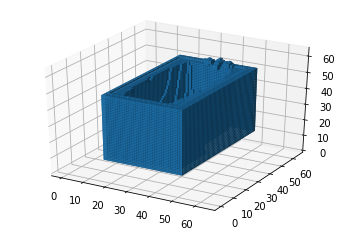

In [5]:
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(train_voxel[0])

plt.show()

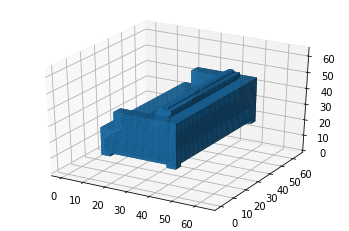

In [6]:
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(train_voxel[3000])

plt.show()

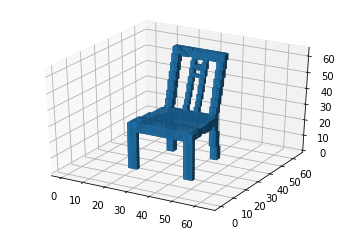

In [7]:
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(train_voxel[1500])

plt.show()

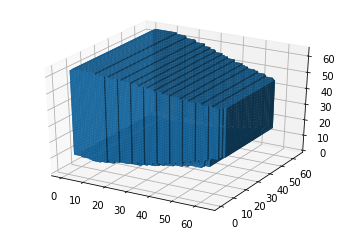

In [8]:
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(train_voxel[2000])

plt.show()

In [9]:
print(train_voxel.shape)

(3991, 64, 64, 64)


In [12]:
opt = Adam(learning_rate=0.0002,beta_1 = 0.5)

In [13]:
def define_discriminator(in_shape=(64,64,64,1)):
  print('inside discriminator')
  model = Sequential()
  model.add(Conv3D(64,(4,4,4), strides=(2,2,2), padding ='same', input_shape = in_shape))
  model.add(LeakyReLU(alpha= 0.00001))
  model.add(BatchNormalization())
  

  model.add(Conv3D(64,(4,4,4), strides=(2,2,2), padding ='same'))
  model.add(LeakyReLU(alpha= 0.00001))
  model.add(BatchNormalization())
  

  model.add(Conv3D(128,(4,4,4), strides=(2,2,2), padding ='same'))
  model.add(LeakyReLU(alpha= 0.00001))
  model.add(BatchNormalization())
  

  model.add(Conv3D(256,(4,4,4), strides=(2,2,2), padding ='same'))
  model.add(LeakyReLU(alpha= 0.00001))
  model.add(BatchNormalization())
  

  model.add(Conv3D(512,(4,4,4), strides=(2,2,2), padding ='same'))
  model.add(LeakyReLU(alpha= 0.00001))
  model.add(BatchNormalization())

  #model.add(Conv3D(512,(4,4,4), strides=(2,2,2), padding ='same'))
  #model.add(LeakyReLU(alpha= 0.00001))
  #model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dropout(0.4))
  ##assert model.output_shape == (None,4096)
  model.add(Dense(64,activation='sigmoid'))
  model.add(Dense(1,activation='sigmoid'))
  #model.add(Reshape(32,32,32))
  model.compile(loss=binary_crossentropy,optimizer=opt, metrics=['accuracy'])
  return model

In [14]:
test_discr = define_discriminator()
print(test_discr.summary())

inside discriminator
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 32, 32, 32, 64)    4160      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32, 64)    0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 16, 16, 64)    262208    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 16, 64)    0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 16, 64)   256       
 hNormalization)                   

In [15]:
def define_generator(latent_dim):
  model = Sequential()
  n_nodes = 200*1*1*1
  #model.add(Dense(n_nodes,input_dim = latent_dim))
  #model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((1,1,1,200)))
  model.add(Conv3DTranspose(512,(4,4,4), strides=(1,1,1),padding='valid'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv3DTranspose(256,(4,4,4), strides=(2,2,2),padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv3DTranspose(128,(4,4,4), strides=(2,2,2),padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv3DTranspose(128,(4,4,4), strides=(2,2,2),padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv3DTranspose(64,(4,4,4), strides=(2,2,2),padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
  #model.add(Conv3DTranspose(128,(4,4,4), strides=(2,2,2),padding='same'))
  #model.add(BatchNormalization())
  #model.add(LeakyReLU(alpha=0.2))
  model.add(Conv3D(1,(8,8,8),activation = 'sigmoid',padding = 'same'))
  return model


In [ ]:
test_gen = define_generator(200)
print(test_gen.summary())

In [17]:
def generate_latent_points(latent_dim,n_samples):
  X_input = np.random.randn(latent_dim * n_samples)
  X_input = X_input.reshape(n_samples,latent_dim)
  return X_input  

In [18]:
def define_gan(generator,discriminator):
  discriminator.trainable = False
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  opt = Adam(learning_rate = 0.0025,beta_1 = 0.5)
  model.compile(loss='binary_crossentropy',optimizer = opt)
  return model

In [19]:
def get_real_samples(train_voxel,n_samples):
  #choose random images
  ix = np.random.randint(0,train_voxel.shape[0],n_samples)
  X = train_voxel[ix]
  #assigning 1 to y indicating real images
  y = np.ones((n_samples,1))
  return X,y

In [20]:
def generate_fake_Samples(generator,latent_dim,n_samples):
  #generate points in latent space
  x_input = generate_latent_points(latent_dim,n_samples)
  #predict using generator to generate fake samples
  X = generator.predict(x_input)
  # labeled as 0 since they are fake samples
  y = np.zeros((n_samples,1))
  return X,y


In [21]:
def train(g_model, d_model,gan_model,train_voxel,latent_dim,n_epochs = 3, n_batch= 10):
  bat_per_epo = int(train_voxel.shape[0] / n_batch)
  half_batch = int(n_batch / 2)

  #training loop
  for i in range(n_epochs):
    for j in range(n_batch):
      
      X_real,y_real = get_real_samples(train_voxel,half_batch)
      #measuring loss of discriminator
      d_loss_real,_ = d_model.train_on_batch(X_real,y_real) 

      #generate fake samples
      X_fake,y_fake = generate_fake_Samples(g_model,latent_dim,half_batch)
      d_loss_fake,_ = d_model.train_on_batch(X_fake,y_fake)

      #prepare latent points as input to the generator
      X_gan = generate_latent_points(latent_dim,n_batch)

      #generated samples are labeled as valid to fool the discriminator
      y_gan = np.ones((n_batch,1))

      #train generator with latent_dim and y as 1
      g_loss = gan_model.train_on_batch(X_gan,y_gan)

      print('Epoch>%d, Batch %d/%d,d1=%.3f,d2=%.3f,g=%.3f' %
            (i+1,j+1,bat_per_epo,d_loss_real,d_loss_fake,g_loss))

In [22]:
#train the gan
#size of latent space
latent_dim = 200
#create the discriminator
discriminator = define_discriminator()
#create the generator
generator = define_generator(latent_dim)
#create gan
gan_model = define_gan(generator,discriminator)
#train model
train(generator,discriminator,gan_model,train_voxel,latent_dim,n_epochs=3)

inside discriminator
1/1 [==============================] - 1s 1s/step
Epoch>1, Batch 1/399,d1=0.455,d2=1.091,g=0.365
1/1 [==============================] - 0s 28ms/step
Epoch>1, Batch 2/399,d1=0.226,d2=0.107,g=0.369
1/1 [==============================] - 0s 27ms/step
Epoch>1, Batch 3/399,d1=0.104,d2=0.014,g=0.371
1/1 [==============================] - 0s 28ms/step
Epoch>1, Batch 4/399,d1=0.042,d2=0.012,g=0.369
1/1 [==============================] - 0s 27ms/step
Epoch>1, Batch 5/399,d1=0.317,d2=0.013,g=0.313
1/1 [==============================] - 0s 28ms/step
Epoch>1, Batch 6/399,d1=0.017,d2=0.013,g=0.292
1/1 [==============================] - 0s 27ms/step
Epoch>1, Batch 7/399,d1=0.046,d2=0.013,g=0.294
1/1 [==============================] - 0s 28ms/step
Epoch>1, Batch 8/399,d1=0.017,d2=0.013,g=0.301
1/1 [==============================] - 0s 27ms/step
Epoch>1, Batch 9/399,d1=0.024,d2=0.012,g=0.306
1/1 [==============================] - 0s 27ms/step
Epoch>1, Batch 10/399,d1=0.008,d2=0.01

In [ ]:
import os.path
discriminator.save('/content/drive/MyDrive/3D-discriminator.h5')

In [ ]:
generator.save('/content/drive/MyDrive/3D-generator.h5')

In [23]:
from tensorflow.keras.models import load_model
temp = load_model('/content/drive/MyDrive/3D-discriminator.h5')

In [24]:
temp.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_11 (Conv3D)          (None, 32, 32, 32, 64)    4160      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 32, 32, 32, 64)    0         
                                                                 
 batch_normalization_15 (Bat  (None, 32, 32, 32, 64)   256       
 chNormalization)                                                
                                                                 
 conv3d_12 (Conv3D)          (None, 16, 16, 16, 64)    262208    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 16, 16, 16, 64)    0         
                                                                 
 batch_normalization_16 (Bat  (None, 16, 16, 16, 64)   256       
 chNormalization)                                     

In [ ]:
temp.get_weights()

In [ ]:
temp.optimizer

In [31]:
layers = temp.layers
print(temp.inputs)
print(temp.layers[5])
print(temp.layers[8])
print(temp.layers[11])
#filters,biases = layers_classifier[1].get_weights()
#print(layers_classifier[1],filters.shape)

[<KerasTensor: shape=(None, 64, 64, 64, 1) dtype=float32 (created by layer 'conv3d_11_input')>]


In [77]:
from tensorflow.keras.layers import MaxPooling3D
opt = Adam(learning_rate=0.001)

In [78]:
def Classifier(temp):
  out1 = tf.keras.layers.MaxPool3D(pool_size=(8,8,8))(temp.layers[5].output)
  out2 = tf.keras.layers.MaxPool3D(pool_size=(4,4,4))(temp.layers[8].output)
  out3 = tf.keras.layers.MaxPool3D(pool_size=(2,2,2))(temp.layers[11].output)
  conc = tf.keras.layers.Concatenate()([out1,out2,out3])
  flat = tf.keras.layers.Flatten()(conc)
  output = tf.keras.layers.Dense(10,activation='softmax')(flat)
  model = tf.keras.Model(inputs = temp.inputs,outputs = output)
  model.compile(loss=sparse_categorical_crossentropy,optimizer=opt, metrics=['accuracy'])
  return model

In [79]:
classifier = Classifier(temp)
print(classifier.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv3d_11_input (InputLayer)   [(None, 64, 64, 64,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d_11 (Conv3D)             (None, 32, 32, 32,   4160        ['conv3d_11_input[0][0]']        
                                64)                                                               
                                                                                                  
 leaky_re_lu_15 (LeakyReLU)     (None, 32, 32, 32,   0           ['conv3d_11[0][0]']              
                                64)                                                         

In [88]:
classifier.fit(x=train_voxel,batch_size=10,epochs=2,y=test_voxel,shuffle=True)

ValueError: ignored